In [1]:
using IPUToolkit.IPUCompiler
using IPUToolkit.Poplar
using DiffEqGPU
using StaticArrays
using OrdinaryDiffEq
using Plots
using Interact

WebIO._IJuliaInit()

In [2]:
ENV["POPLAR_RUNTIME_OPTIONS"] = """{"target.hostSyncTimeout":"60"}"""
IPUCompiler.KEEP_LLVM_FILES[] = true;

In [3]:
function lotka_volterra(u, p, t)
    α, β, γ, δ = p
    🐁, 🐈 = u
    d🐁 = α * 🐁 - β * 🐁 * 🐈
    d🐈 = -γ * 🐈 + δ * 🐁 * 🐈
    return SVector{2}(d🐁, d🐈)
end

lotka_volterra (generic function with 1 method)

In [4]:
N_lotka_volterra = 20_000

T_lotka_volterra = Float16
α_lotka_volterra_range = range(T_lotka_volterra(0.1); step=T_lotka_volterra(0.1), length=64)
β_lotka_volterra_range = range(T_lotka_volterra(0.1); step=T_lotka_volterra(0.1), length=23)

# Create a range of different input parameters
lotka_volterra_parameters = let
    α = repeat(α_lotka_volterra_range; inner=23)
    β = repeat(β_lotka_volterra_range; outer=64)
    γ = repeat([T_lotka_volterra(3)], length(β))
    δ = repeat([T_lotka_volterra(1)], length(β))
    zip(α, β, γ, δ) |> Iterators.flatten |> collect
end;

In [5]:
function lotka_volterra_cpu(p::Vector,
                            n::Integer,
                            timestep::Real,
                            FT::DataType=Float64)
    u1 = Vector{FT}(undef, n)
    u2 = Vector{FT}(undef, n)
    u0 = @SVector [FT(1); FT(1)]
    svp = @inbounds SVector{4, FT}(p)
    integ = DiffEqGPU.init(GPUTsit5(), lotka_volterra, false, u0, FT(0), FT(timestep), svp, nothing, CallbackSet(nothing), true, false)

    for idx in eachindex(u1, u2)
        DiffEqGPU.step!(integ, integ.t + integ.dt, integ.u)
        u1[idx] = integ.u[1]
        u2[idx] = integ.u[2]
    end

    return u1, u2
end

lotka_volterra_cpu (generic function with 2 methods)

In [6]:
device = Poplar.get_ipu_device()
target = Poplar.DeviceGetTarget(device)
graph = Poplar.Graph(target)

tile_clock_frequency = Poplar.TargetGetTileClockFrequency(target)
num_tiles = Int(Poplar.TargetGetNumTiles(target))
tiles = 0:(num_tiles - 1)

@codelet graph function solve_lv(u1::VertexVector{Float16, IPUCompiler.Out},
                                 u2::VertexVector{Float16, IPUCompiler.Out},
                                 p::VertexVector{Float16, IPUCompiler.In},
                                 cycles::VertexVector{UInt32, IPUCompiler.Out})
    u0 = @SVector [Float16(1); Float16(1)]
    svp = @inbounds SVector{4, Float16}(p)
    integ = DiffEqGPU.init(GPUTsit5(), lotka_volterra, false, u0, Float16(0), Float16(0.001), svp, nothing, CallbackSet(nothing), true, false)
    cycles[begin] = @ipuelapsed for idx in eachindex(u1, u2)
        DiffEqGPU.step!(integ, integ.t + integ.dt, integ.u)
        u1[idx] = integ.u[1]
        u2[idx] = integ.u[2]
    end
end

FT = T_lotka_volterra
len = N_lotka_volterra * (length(lotka_volterra_parameters) ÷ 4)
u1_16 = Vector{FT}(undef, len)
u2_16 = Vector{FT}(undef, len)
u1_16_sr = Vector{FT}(undef, len)
u2_16_sr = Vector{FT}(undef, len)
cycles = Vector{UInt32}(undef, num_tiles)
cycles_sr = Vector{UInt32}(undef, num_tiles)

p_ipu =  Poplar.GraphAddConstant(graph, lotka_volterra_parameters)

for sr in (true, false)
    prog = Poplar.ProgramSequence()
    Poplar.PoplarSetStochasticRounding(graph, prog, sr, "")

    u1_ipu = similar(graph, sr ? u1_16_sr : u1_16)
    u2_ipu = similar(graph, sr ? u2_16_sr : u2_16)
    cycles_ipu = similar(graph, sr ? cycles_sr : cycles)

    # Run the codelet defined above on all tiles,
    # with tensors evenly spread across all cores.
    add_vertex(graph, prog, tiles, solve_lv, u1_ipu, u2_ipu, p_ipu, cycles_ipu)

    # Prepare tensors read
    Poplar.GraphCreateHostRead(graph, "u1-$(sr ? "sr-" : "")read", u1_ipu)
    Poplar.GraphCreateHostRead(graph, "u2-$(sr ? "sr-" : "")read", u2_ipu)
    Poplar.GraphCreateHostRead(graph, "cycles-$(sr ? "sr-" : "")read", cycles_ipu)

    # Run the program
    engine = Poplar.Engine(graph, prog)
    Poplar.EngineLoadAndRun(engine, device)

    # Read the output tensors back to the CPU
    Poplar.EngineReadTensor(engine, "u1-$(sr ? "sr-" : "")read", sr ? u1_16_sr : u1_16)
    Poplar.EngineReadTensor(engine, "u2-$(sr ? "sr-" : "")read", sr ? u2_16_sr : u2_16)
    Poplar.EngineReadTensor(engine, "cycles-$(sr ? "sr-" : "")read", sr ? cycles_sr : cycles)
end

Poplar.detach_devices()

time = round(maximum(cycles) / tile_clock_frequency; sigdigits=3)
time_sr = round(maximum(cycles_sr) / tile_clock_frequency; sigdigits=3)

@info "Solving $(length(lotka_volterra_parameters) ÷ 4) ODEs on $(num_tiles) tiles took $(time) seconds with NR, and $(time_sr) with SR."

[ Info: Trying to attach to device 0...
[ Info: Successfully attached to device 0
✓ Compiling codelet solve_lv: 	 Time: 0:00:09
[ Info: Solving 1472 ODEs on 1472 tiles took 0.0253 seconds with NR, and 0.0253 with SR.


In [7]:
Poplar.detach_devices()

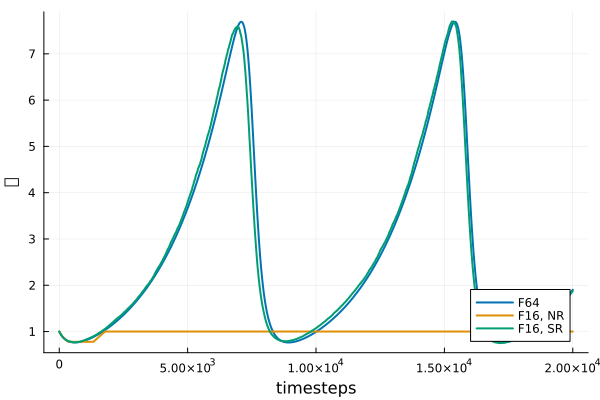

GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001
GKS: glyph missing from current font: 128001


In [8]:
# Sorry, I have no idea how to make `Interact.@manipulate` work!
lotka_volterra_var = "🐁" # "🐁" or "🐈"
α_lotka_volterra = Float16(0.4) # Number in 0.1:0.1:6.4
β_lotka_volterra = Float16(1.5) # Number in 0.1:0.1:2.3

idx = lotka_volterra_var == "🐁" ? 1 : 2
# Find the index corresponding to the chosen parameters
n = first(intersect(
    findall(==(α_lotka_volterra), lotka_volterra_parameters[1:4:end]),
    findall(==(β_lotka_volterra), lotka_volterra_parameters[2:4:end])))
linewidth = 2
# Compute the slice
slice = ((n - 1) * N_lotka_volterra + 1):(n * N_lotka_volterra)
# Plot the solution
fig = plot(lotka_volterra_cpu(Float64[α_lotka_volterra, β_lotka_volterra, lotka_volterra_parameters[3], lotka_volterra_parameters[4]], N_lotka_volterra, 0.001, Float64)[idx];
           label="F64",
           xlabel="timesteps",
           ylabel=lotka_volterra_var,
           legend=:bottomright,
           linewidth,
           palette=:seaborn_colorblind,
           )
plot!(fig, (lotka_volterra_var == "🐁" ? u1_16 : u2_16)[slice];
      label="F16, NR",
      linewidth,
      )
plot!(fig, (lotka_volterra_var == "🐁" ? u1_16_sr : u2_16_sr)[slice];
      label="F16, SR",
      linewidth,
      )